### Summary of Results When Combining CT Scan with RT-PCR (Given Sensitivity and Specificity)

In [387]:
"""
This function uses Bayes's law to return P(A|B) given P(A), P(B), P(Ac|Bc),
where event Xc denotes the complement of event X.
"""
def A_given_B(A, B_given_A, Bc_given_Ac):
    return (B_given_A * A) / (B_given_A * A + complement(Bc_given_Ac) * complement(A))

"""Gives the probability of the complement of event A"""
def complement(X):
    return 1 - X

**I'll denote sensitivity by "tp" (true positive) and specificity by "tn" (true negative). Fill in the following dictionaries with the sensitivity value and specificity range (low, high) for each test.**    
*Note: the true positive rate (sensitivity) is the probability that the test is positive given that the patient has the disease. Likewise, the true negative rate (specificity) is the probability that the test comes back negative given that the patient is healthy.*

In [388]:
"""All rates must be in the range [0, 1]"""

# sensitivity and specificity for RT_PCR test
RT_PCR = {'name': 'RT-PCR', 'tp': 0.99, 'tn': (0.80, 0.99)}

# sensitivity and specificity for CT Scan test
CT = {'name': 'CT-Scan', 'tp': 0.70, 'tn': (0.80, 0.99)}

## Calculating Probabilities Using Different Tests
*For the following cells, let A := P(patient is infected), Ac := P(patient is not infected), B := P(test comes back positive), and Bc := P(test comes back negative)*

In [389]:
# Fill in the estimated percentage of infected people in the desired population
# Must be in the range [0, 1]
A = .05 #0.29
# this number is taken from a worst-case peak estimate in
# https://www.nytimes.com/2020/03/13/us/coronavirus-deaths-estimate.html

In [390]:
"""
Returns the probability range that a patient is infected given that TEST comes back positive
"""
def infected_range(test):
    return (
        A_given_B(A, test['tp'], test['tn'][0]), 
        A_given_B(A, test['tp'], test['tn'][1])
    )

"""
Returns the probability range that a patient is healthy given that TEST comes back negative
"""
def healthy_range(test):
    return (
        A_given_B(complement(A), test['tn'][0], test['tp']), 
        A_given_B(complement(A), test['tn'][1], test['tp'])
    )

"""
Finds the probability that the test returns a false positive or a false negative.
Given our definitions of A and B, this means finding P(A⋂Bc) + P(Ac⋂B)
"""
def error_range(test):
    fn = A*complement(test['tp'])
    fp = (complement(A) * complement(test['tn'][0]),
          complement(A) * complement(test['tn'][1]))
    return (fn + fp[0], fn + fp[1])

In [391]:
"""
Function to evaluate and print the results of TEST.
"""
def evaluate(test):
    name = test['name']
    
    infected = infected_range(test)
    print("Probability of infection given positive {0} result ranges from {1} to {2}".format(
        name, infected[0], infected[1]))
    
    healthy = healthy_range(test)
    print("Probability of no infection given negative {0} result ranges from {1} to {2}".format(
        name, healthy[0], healthy[1]))
    
    error = error_range(test)
    print("Probability that {0} errors ranges from {1} to {2}".format(name, error[0], error[1]))

**Probability of each case using one RT_PCR Test**

In [392]:
evaluate(RT_PCR)

Probability of infection given positive RT-PCR result ranges from 0.2066805845511483 to 0.8389830508474575
Probability of no infection given negative RT-PCR result ranges from 0.9993425378040762 to 0.9994686503719447
Probability that RT-PCR errors ranges from 0.19049999999999995 to 0.010000000000000009


**Probability of each case using one CT Scan Test**

In [393]:
evaluate(CT)

Probability of infection given positive CT-Scan result ranges from 0.15555555555555559 to 0.7865168539325841
Probability of no infection given negative CT-Scan result ranges from 0.9806451612903225 to 0.9843014128728415
Probability that CT-Scan errors ranges from 0.20499999999999996 to 0.02450000000000001


## Now, let's calculate similar probabilities if we perform a CT scan directly after an RT-PCR
**Note that in this scenario, if we wish to deal with multiple tests, then we must assume they're independent (conditioned on A). Otherwise we would need to know their fp/tn rates given that previous tests came back positive or negative.**

In [394]:
import numpy as np

In [395]:
"""
- This function takes a list of tuples, each formatted as (test, positive), where positive is a boolean that
    is true iff the test returns positive.
- Also takes argument A, the percentage of people in the population who are infected.
- It evaluates assuming all tests are independent conditioned on whether or
    not the patient is infected.
- Applies the first test in the argument list first, and then moves sequentially towards the end.
- Returns the probability that the patient is infected given the test results
"""
def range_multi(A, tests):
    tests_and_A = A
    
    # maintain max index as 0 index since we will be taking reciproval
    tests_and_Ac = np.ones(2) * complement(A)
    for test, positive in tests:
        tn = np.array(test['tn'])
        
        if positive:
            # taking complement of tn causes 0 index to be greater
            test_val, test_complement = test['tp'], complement(tn)
        else:
            # flip tn so that 0 index is greater
            test_val, test_complement = complement(test['tp']), np.flip(tn)
            
        tests_and_A *= test_val
        
        # element-wise multiplication
        tests_and_Ac = np.multiply(tests_and_Ac, test_complement)
    
    return tests_and_A / (tests_and_A + tests_and_Ac)

**Let's also make a function to display the results on a graph**

In [396]:
%matplotlib inline
import matplotlib.pyplot as plt

In [397]:
"""
Function to display a percentage range on the number line. pRange is a tuple (min, max) containing
probabilities from 0 to 1.
"""
def show(pRange):
    # set up the figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(0,10)
    ax.set_ylim(0,10)

    # draw lines
    xmin = 0
    xmax = 10
    y = 5
    height = 1

    plt.hlines(y, xmin, xmax)
    plt.vlines(xmin, y - height / 2., y + height / 2.)
    plt.vlines(xmax, y - height / 2., y + height / 2.)

    # draw a point on the line
    xMin = pRange[0] * 10
    plt.plot(xMin,y, 'ro', ms = 10, mfc = 'r')

    xMax = pRange[1] * 10
    plt.plot(xMax,y, 'ro', ms = 10, mfc = 'r')

    plt.plot([xMin, xMax], [y, y], 'r')

    # add an arrow
    plt.annotate("{0:.2f}%".format(xMin*10), (xMin,y), xytext = (xMin - 1, y + 2), 
                  arrowprops=dict(facecolor='black', shrink=0.1), 
                  horizontalalignment='left')
    plt.annotate("{0:.2f}%".format(xMax*10), (xMax, y), xytext = (xMax + 1, y + 2),
                arrowprops=dict(facecolor='black', shrink=0.1), 
                  horizontalalignment='right')

    # add numbers
    plt.text(xmin - 0.1, y, '0%', horizontalalignment='right')
    plt.text(xmax + 0.1, y, '100%', horizontalalignment='left')

    plt.axis('off')
    plt.show()

**Using this function, we can display the updated probability of infection given a positive RT-PCR result and a positive CT Scan result.**

The probability of infection given a True RT-PCR result and a True CT-Scan result is between 0.4769 and 0.9973


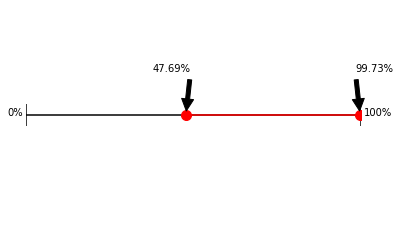

In [398]:
# Positive RT-PCR result and positive CT result
tests = [(RT_PCR, True), (CT, True)]
pRange = range_multi(A, tests)

print("The probability of infection given a {0} {1} result and a {2} {3} result is between {4:.4f} and {5:.4f}".format(
    tests[0][1], tests[0][0]['name'], tests[1][1], tests[1][0]['name'], pRange[0], pRange[1]))

show(pRange)

# Interactive

**Let's introduce an interactive component so we can choose which tests to use, as well as their sentitivity and specificity.**  
The following two cells are setup.

In [399]:
import ipywidgets as widgets
from ipywidgets import interactive, interact
from IPython.display import display

In [400]:
"""
This function generates sliders and check boxes for each test in the given selection, and displays
the testing results on a number line.
"""
def selection_test(selection):
    
    """
    Kwargs are a list of unpacked tests: positive, sensitivity, specificity
        - passed is a boolean denoting whether or not the test was positive
        - sentitivity is a percentage (0 to 100)
        - specificity is a percentage range
    Each test needs these 3 values.
    """
    def interactive_func(A, **kwargs):
        
        tests = []
        i = 0
        for name in selection.value:
            test = {'name':name}
            pos = kwargs['arg{}'.format(i)]
            test['tp'] = kwargs['arg{}'.format(i + 1)] / 100
            test['tn'] = np.array(kwargs['arg{}'.format(i + 2)]) / 100
            tests.append((test, pos))
            i+=3
        
        pRange = range_multi(A / 100, tests)
        show(pRange)
            
    
    A_slider = widgets.FloatSlider(
        value=A*100,
        min=0,
        max=100.0,
        step=0.01,
        description='% Infected',
        disabled=False,
        indent=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.2f',
    )
    
    arguments = {}
    i = 0
    for name in selection.value:
        arguments['arg{}'.format(i)] = widgets.Checkbox(value=True, description=name, indent=False)
        if (i // 3) % 2:
            ref = CT
        else:
            ref = RT_PCR
        
        arguments['arg{}'.format(i + 1)] = widgets.FloatSlider(
            value=ref['tp']*100, min=0, max=100.0, step=0.01,
            description='sensitivity',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.2f',
        )
        
        arguments['arg{}'.format(i + 2)] = widgets.FloatRangeSlider(
            value=[ref['tn'][0]*100, ref['tn'][1]*100], 
            min=0, max=100.0, step=0.01,
            description='specificity',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.2f',
        )
        
        i += 3
        
    return interactive_func, A_slider, arguments

**The following cell allows you to choose which tests to perform. Use Cmd+Click to select multiple.**  
Note that "RT-PCR 2" is a second RT-PCR test performed 3 days later.

In [401]:
selection = widgets.SelectMultiple(
    options=['RT-PCR 1', 'CT', 'RT-PCR 2'],
    value=selection.value,
    description='Tests',
)
display(selection)

SelectMultiple(description='Tests', index=(0, 1), options=('RT-PCR 1', 'CT', 'RT-PCR 2'), value=('RT-PCR 1', '…

**Run the following cell to generate the testing module. The check box next to each test indicates whether the test returned positive or negative (checked is positive). The sliders dictate the sensitivity and specificity for each test. After setting the sliders and the check boxes, click "run interact" to generate the number line. The range on the number line represents the probability range that a patient is infected given the test results.**

In [402]:
interactive_func, A_slider, arguments = selection_test(selection)
interactive_plot = interactive(interactive_func, {'manual': True}, A=A_slider, **arguments)
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='% Infected', step=0.01), Ch…